<div style="text-align: center; font-size: 40px; color: #3498db; font-weight: bold;">
    Purchasing Power Parity and Time Series Forecasting
</div>

<div style="font-size: 20px; font-weight: normal; margin-top: 20px;text-align: center;color: #3498db">
    <div style="margin-top: 8px;">
        Omkar Phadtare - https://www.linkedin.com/in/omkarphadtare/ <br>
    </div>
</div>

<div style="text-align: center; font-size: 30px; color: #3498db; font-weight: bold;">
    Introduction
</div>

### In this project, we explore the economic relationship between two countries - India (home country) and Ireland (foreign country), through the lens of Purchasing Power Parity (PPP) theory. The goal is to evaluate both the absolute and relative forms of PPP, and forecast the real exchange rate (RER) using time-series modeling techniques (primarily the Box-Jenkins methodology).

#### **Our dataset spans over 10 years (2014-2024), containing:**

- **Nominal Exchange Rate (INR per EUR)**

- **Consumer Price Index (CPI) for India**

- **Consumer Price Index (CPI) for Ireland**

<div style="text-align: center; font-size: 30px; color: #3498db; font-weight: bold;">
    Data Collection
</div>

In this step, we import the time series datasets required for our analysis:

- **Consumer Price Index (CPI)** for India
- **Consumer Price Index (CPI)** for Ireland
- **Nominal Exchange Rate (EUR/INR)**

These datasets cover the period from 2014 to 2024 and will be used to construct the Real Exchange Rate (RER) and test Purchasing Power Parity (PPP).


In [419]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import statsmodels.api as sm
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats
from IPython.display import display
from statsmodels.stats.diagnostic import acorr_ljungbox

In [420]:
warnings.filterwarnings('ignore')

india_cpi = pd.read_excel("INDIA CPI.xlsx")
ireland_cpi = pd.read_excel("IRL CPI.xlsx")
exchange_rate = pd.read_csv("EUR_INR Historical Data.csv")

print("India CPI:")
display(india_cpi.head())

print("Ireland CPI:")
display(ireland_cpi.head())

print("Exchange Rate (EUR to INR):")
display(exchange_rate.head())

India CPI:


,observation_date,INDCPIALLAINMEI
0,1957-01-01,1.525411
1,1958-01-01,1.598252
2,1959-01-01,1.671093
3,1960-01-01,1.700837
4,1961-01-01,1.729669


Ireland CPI:


,observation_date,IRLCPIALLAINMEI
0,1976-01-01,16.96255
1,1977-01-01,19.24778
2,1978-01-01,20.73200
3,1979-01-01,23.48842
4,1980-01-01,27.75261


Exchange Rate (EUR to INR):


,Date,Price,Change %
0,1/1/2014,84.524,-0.49%
1,1/1/2015,69.985,-8.21%
2,1/1/2016,73.528,2.28%
3,1/1/2017,72.862,2.00%
4,1/1/2018,78.917,3.07%


<div style="text-align: center; font-size: 30px; color: #3498db; font-weight: bold;">
    Data Preprocessing
</div>

Before we can analyze or model the data, it is essential to clean and prepare it. This ensures accuracy and consistency throughout the forecasting process.

In this step, we:

- Rename columns for clarity and consistency  
- Convert date columns to datetime format  
- Handle missing or irregular data  
- Standardize the dataset to span from 2014 to 2024

Cleaned India CPI:


,Date,CPI_INDIA
0,2014-01-01,94.4533
1,2015-01-01,100.0000
2,2016-01-01,104.9410
3,2017-01-01,107.5550
4,2018-01-01,112.7829


Cleaned Ireland CPI:


,Date,CPI_IRELAND
0,2014-01-01,100.3321
1,2015-01-01,100.0000
2,2016-01-01,100.0201
3,2017-01-01,100.3824
4,2018-01-01,100.8553


Cleaned Exchange Rate:


,Date,EXCHANGE_RATE,Change %
0,2014-01-01,84.524,-0.49%
1,2015-01-01,69.985,-8.21%
2,2016-01-01,73.528,2.28%
3,2017-01-01,72.862,2.00%
4,2018-01-01,78.917,3.07%


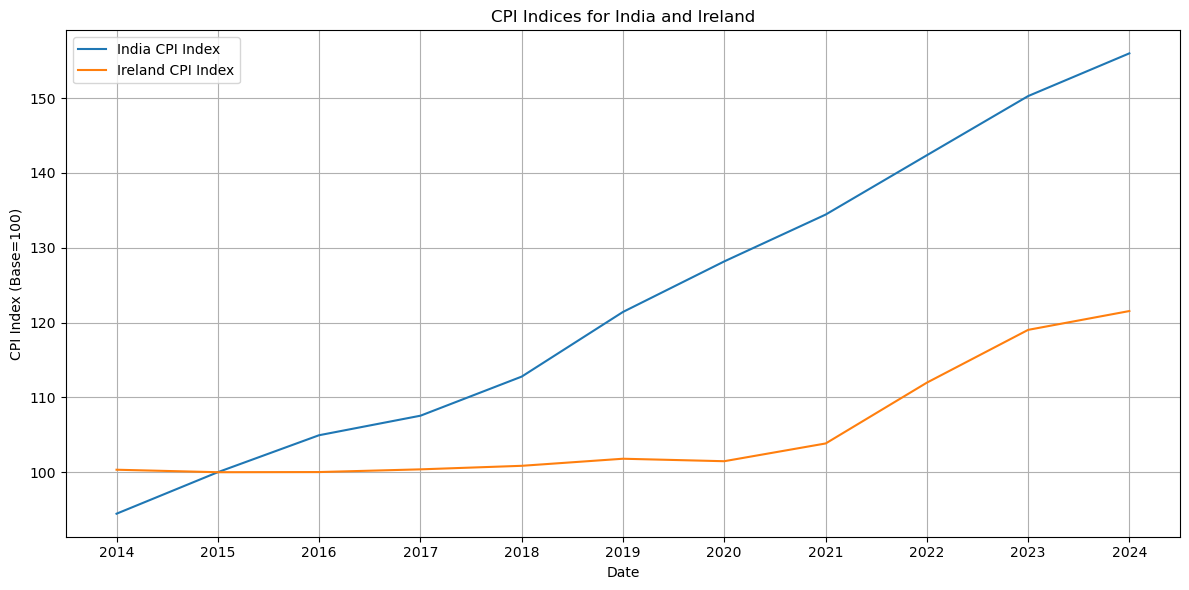

In [422]:
# --- India CPI ---
india_cpi.columns = ["Date", "CPI_INDIA"]
india_cpi["Date"] = pd.to_datetime(india_cpi["Date"])
india_cpi = india_cpi[(india_cpi["Date"].dt.year >= 2014) & (india_cpi["Date"].dt.year <= 2024)]

# --- Ireland CPI ---
ireland_cpi.columns = ["Date", "CPI_IRELAND"]
ireland_cpi["Date"] = pd.to_datetime(ireland_cpi["Date"])
ireland_cpi = ireland_cpi[(ireland_cpi["Date"].dt.year >= 2014) & (ireland_cpi["Date"].dt.year <= 2024)]

# --- Exchange Rate (EUR/INR) ---
exchange_rate.columns = ["Date", "EXCHANGE_RATE", "Change %"]
exchange_rate["Date"] = pd.to_datetime(exchange_rate["Date"])
exchange_rate = exchange_rate[(exchange_rate["Date"].dt.year >= 2014) & (exchange_rate["Date"].dt.year <= 2024)]
exchange_rate["EXCHANGE_RATE"] = pd.to_numeric(exchange_rate["EXCHANGE_RATE"], errors='coerce')

# Drop any missing values from all
india_cpi.dropna(inplace=True)
ireland_cpi.dropna(inplace=True)
exchange_rate.dropna(inplace=True)

# Reset indices
india_cpi.reset_index(drop=True, inplace=True)
ireland_cpi.reset_index(drop=True, inplace=True)
exchange_rate.reset_index(drop=True, inplace=True)

# Display cleaned versions
print("Cleaned India CPI:")
display(india_cpi.head())

print("Cleaned Ireland CPI:")
display(ireland_cpi.head())

print("Cleaned Exchange Rate:")
display(exchange_rate.head())

# Plot the CPI indices to visualize
plt.figure(figsize=(12, 6))
plt.plot(india_cpi['Date'], india_cpi['CPI_INDIA'], label='India CPI Index')
plt.plot(ireland_cpi['Date'], ireland_cpi['CPI_IRELAND'], label='Ireland CPI Index')
plt.title('CPI Indices for India and Ireland')
plt.xlabel('Date')
plt.ylabel('CPI Index (Base=100)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<div style="text-align: center; font-size: 25px; color: #3498db; font-weight: bold;">
    Insights
</div>

1. India’s CPI shows a consistent and steep rise from 2014 to 2024, indicating strong and sustained inflation.
2. Ireland’s CPI remained relatively flat until 2021, after which it accelerated moderately, highlighting a delayed inflationary trend.

<div style="text-align: center; font-size: 30px; color: #3498db; font-weight: bold;">
    Log Transformation
</div>

To stabilize variance and prepare for linear modeling, we apply the natural logarithm to all variables:

- Nominal Exchange Rate (EUR to INR)
- Consumer Price Index for India
- Consumer Price Index for Ireland

These log-transformed series will also be used to calculate the Real Exchange Rate (RER) in the next step.

In [425]:
india_cpi["log_CPI_INDIA"] = np.log(india_cpi["CPI_INDIA"])
ireland_cpi["log_CPI_IRELAND"] = np.log(ireland_cpi["CPI_IRELAND"])
exchange_rate["log_EXCHANGE_RATE"] = np.log(exchange_rate["EXCHANGE_RATE"])

# Display transformed values
print("India CPI (log):")
display(india_cpi[["Date", "CPI_INDIA", "log_CPI_INDIA"]].head())

print("Ireland CPI (log):")
display(ireland_cpi[["Date", "CPI_IRELAND", "log_CPI_IRELAND"]].head())

print("Exchange Rate (log):")
display(exchange_rate[["Date", "EXCHANGE_RATE", "log_EXCHANGE_RATE"]].head())

India CPI (log):


,Date,CPI_INDIA,log_CPI_INDIA
0,2014-01-01,94.4533,4.548106
1,2015-01-01,100.0000,4.605170
2,2016-01-01,104.9410,4.653398
3,2017-01-01,107.5550,4.678002
4,2018-01-01,112.7829,4.725465


Ireland CPI (log):


,Date,CPI_IRELAND,log_CPI_IRELAND
0,2014-01-01,100.3321,4.608486
1,2015-01-01,100.0000,4.605170
2,2016-01-01,100.0201,4.605371
3,2017-01-01,100.3824,4.608987
4,2018-01-01,100.8553,4.613687


Exchange Rate (log):


,Date,EXCHANGE_RATE,log_EXCHANGE_RATE
0,2014-01-01,84.524,4.437036
1,2015-01-01,69.985,4.248281
2,2016-01-01,73.528,4.297666
3,2017-01-01,72.862,4.288567
4,2018-01-01,78.917,4.368397


<div style="text-align: center; font-size: 30px; color: #3498db; font-weight: bold;">
    Compute Real Exchange Rate (RER)
</div>

The **Real Exchange Rate (RER)** provides an inflation-adjusted view of the nominal exchange rate. It reflects the true purchasing power of one currency relative to another, considering differences in price levels between countries.

---

We compute the RER using the formula:

$$
\text{RER} = \text{Exchange Rate (EUR/INR)} \times \left( \frac{\text{CPI}_{\text{Ireland}}}{\text{CPI}_{\text{India}}} \right)
$$

To make the data easier to interpret and model, we take the natural logarithm:

$$
\log(\text{RER}) = \log(\text{Exchange Rate}) + \log(\text{CPI}_{\text{Ireland}}) - \log(\text{CPI}_{\text{India}})
$$

---

This transformation:

- Normalizes the data scale
- Makes time-series modeling (e.g., ARIMA) more stable
- Helps meet the assumptions required for stationarity testing


Below, we visualize the following over time:

- **Log CPI** of India and Ireland
- **Log Nominal Exchange Rate**
- **Log Real Exchange Rate (RER)**

Merged Dataset with RER and log_RER:


,Date,RER,log_RER
0,2014-01-01,89.784798,4.497416
1,2015-01-01,69.985000,4.248281
2,2016-01-01,70.080120,4.249639
3,2017-01-01,68.002998,4.219552
4,2018-01-01,70.570962,4.256619


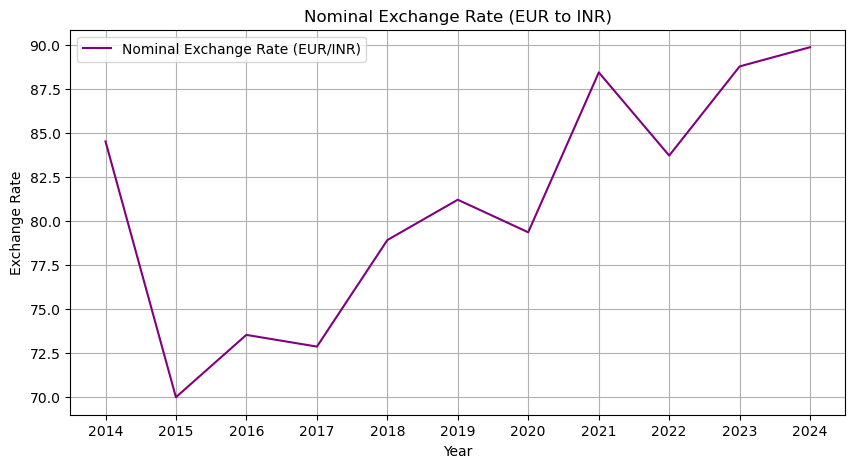

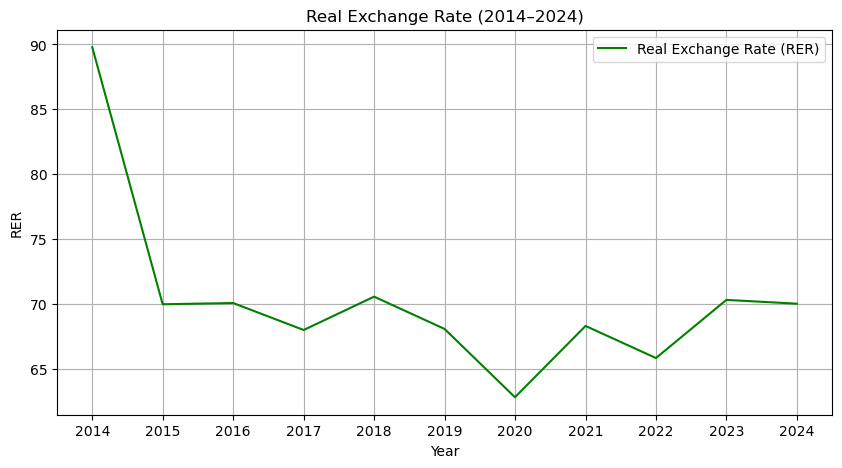

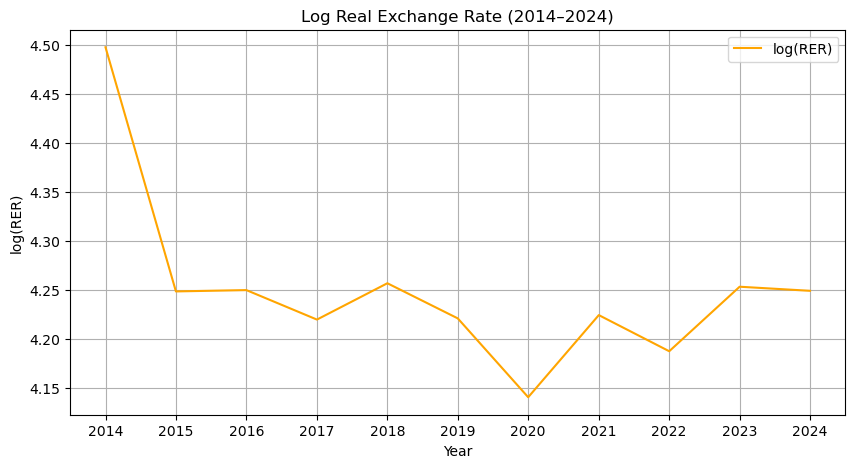

In [427]:
# First, merge the three datasets on "Date"
merged_df = pd.merge(exchange_rate[["Date", "EXCHANGE_RATE", "log_EXCHANGE_RATE"]],
                     india_cpi[["Date", "CPI_INDIA", "log_CPI_INDIA"]],
                     on="Date")
merged_df = pd.merge(merged_df,
                     ireland_cpi[["Date", "CPI_IRELAND", "log_CPI_IRELAND"]],
                     on="Date")

# Compute RER
merged_df["RER"] = merged_df["EXCHANGE_RATE"] * (merged_df["CPI_IRELAND"] / merged_df["CPI_INDIA"])

# Compute log(RER)
merged_df["log_RER"] = merged_df["log_EXCHANGE_RATE"] + merged_df["log_CPI_IRELAND"] - merged_df["log_CPI_INDIA"]

# Show result
print("Merged Dataset with RER and log_RER:")
display(merged_df[["Date", "RER", "log_RER"]].head())



# Plot Exchange Rate
plt.figure(figsize=(10, 5))
plt.plot(merged_df["Date"], merged_df["EXCHANGE_RATE"], label="Nominal Exchange Rate (EUR/INR)", color="purple")
plt.title("Nominal Exchange Rate (EUR to INR)")
plt.xlabel("Year")
plt.ylabel("Exchange Rate")
plt.grid(True)
plt.legend()
plt.show()

# Plot Real Exchange Rate
plt.figure(figsize=(10, 5))
plt.plot(merged_df["Date"], merged_df["RER"], label="Real Exchange Rate (RER)", color="green")
plt.title("Real Exchange Rate (2014–2024)")
plt.xlabel("Year")
plt.ylabel("RER")
plt.grid(True)
plt.legend()
plt.show()

# Plot log_RER
plt.figure(figsize=(10, 5))
plt.plot(merged_df["Date"], merged_df["log_RER"], label="log(RER)", color="orange")
plt.title("Log Real Exchange Rate (2014–2024)")
plt.xlabel("Year")
plt.ylabel("log(RER)")
plt.grid(True)
plt.legend()
plt.show()

<div style="text-align: center; font-size: 25px; color: #3498db; font-weight: bold;">
    Insights
</div>

1. The nominal exchange rate (EUR to INR) increased overall from 2014 to 2024, indicating a depreciation of the Indian Rupee against the Euro.
2. The real exchange rate (RER), adjusted for CPI differences, remained relatively stable post 2015, suggesting inflation offset nominal movements, aligning with Purchasing Power Parity (PPP).
3. The log-transformed RER displays a smoother trend and is more suitable for statistical modeling such as ARIMA and stationarity testing.

<div style="text-align: center; font-size: 30px; color: #3498db; font-weight: bold;">
    Exploratory Data Analysis (EDA)
</div>



In this step, we visually inspect the log-transformed variables to explore patterns and structural characteristics of the time series.

We aim to identify:

- Long-term trends  
- Potential seasonality  
- Changes in volatility  

These visual insights guide our understanding of the data and help determine whether the series are stationary or require differencing before moving to forecasting and statistical testing.


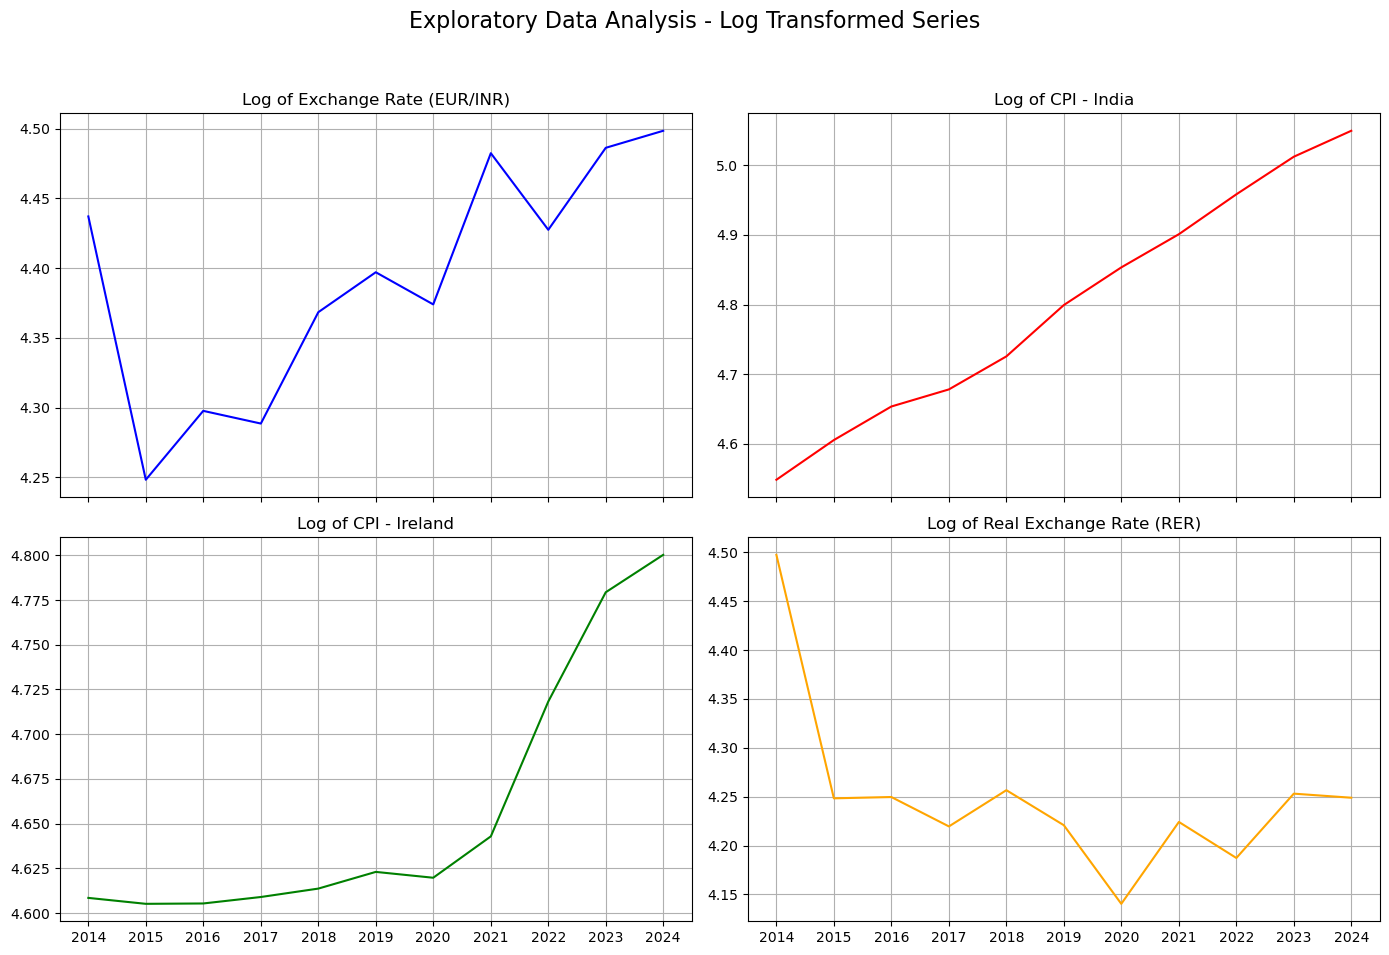

In [430]:
# Plot all log-transformed variables together
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)

axes[0, 0].plot(merged_df["Date"], merged_df["log_EXCHANGE_RATE"], color='blue')
axes[0, 0].set_title("Log of Exchange Rate (EUR/INR)")
axes[0, 0].grid(True)

axes[0, 1].plot(merged_df["Date"], merged_df["log_CPI_INDIA"], color='red')
axes[0, 1].set_title("Log of CPI - India")
axes[0, 1].grid(True)

axes[1, 0].plot(merged_df["Date"], merged_df["log_CPI_IRELAND"], color='green')
axes[1, 0].set_title("Log of CPI - Ireland")
axes[1, 0].grid(True)

axes[1, 1].plot(merged_df["Date"], merged_df["log_RER"], color='orange')
axes[1, 1].set_title("Log of Real Exchange Rate (RER)")
axes[1, 1].grid(True)

plt.suptitle("Exploratory Data Analysis - Log Transformed Series", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


<div style="text-align: center; font-size: 25px; color: #3498db; font-weight: bold;">
    Insights
</div>

1. The log of the nominal exchange rate (EUR/INR) shows a rising trend with minor fluctuations, indicating a gradual depreciation of the Indian Rupee.
2. The log CPI for India follows a strong linear upward trend, suggesting consistent inflation over the years.
3. The log CPI for Ireland remains relatively flat until 2021 and then picks up, showing delayed inflationary effects compared to India.
4. The log of the real exchange rate (RER) stabilizes after 2015, showing minor fluctuations, an indication that price-adjusted exchange rates remained fairly steady, aligning with the expectations under relative Purchasing Power Parity (PPP).

<div style="text-align: center; font-size: 30px; color: #3498db; font-weight: bold;">
     Stationarity Check
</div>

To build reliable time series models such as ARIMA, the data must be stationary, meaning it should have a constant mean and variance over time.

We assess stationarity using the following methods:

- ADF Test (Augmented Dickey-Fuller): Tests for the presence of unit roots  
- ACF and PACF Plots: Visual tools to examine autocorrelations at various lags  
- Differencing: If the series is non-stationary, we apply first-order differencing and repeat the checks  

This step ensures that the underlying assumptions for forecasting models are satisfied.


ADF Test: Log of Real Exchange Rate
ADF Statistic: -6.799278128206112
p-value: 2.258736961534836e-09
# Lags Used: 0
# Observations: 10
Series is stationary (reject H₀)
------------------------------------------------------------

ADF Test: Differenced Log of Real Exchange Rate
ADF Statistic: -5.949242454612805
p-value: 2.1669451367745783e-07
# Lags Used: 0
# Observations: 9
Series is stationary (reject H₀)
------------------------------------------------------------


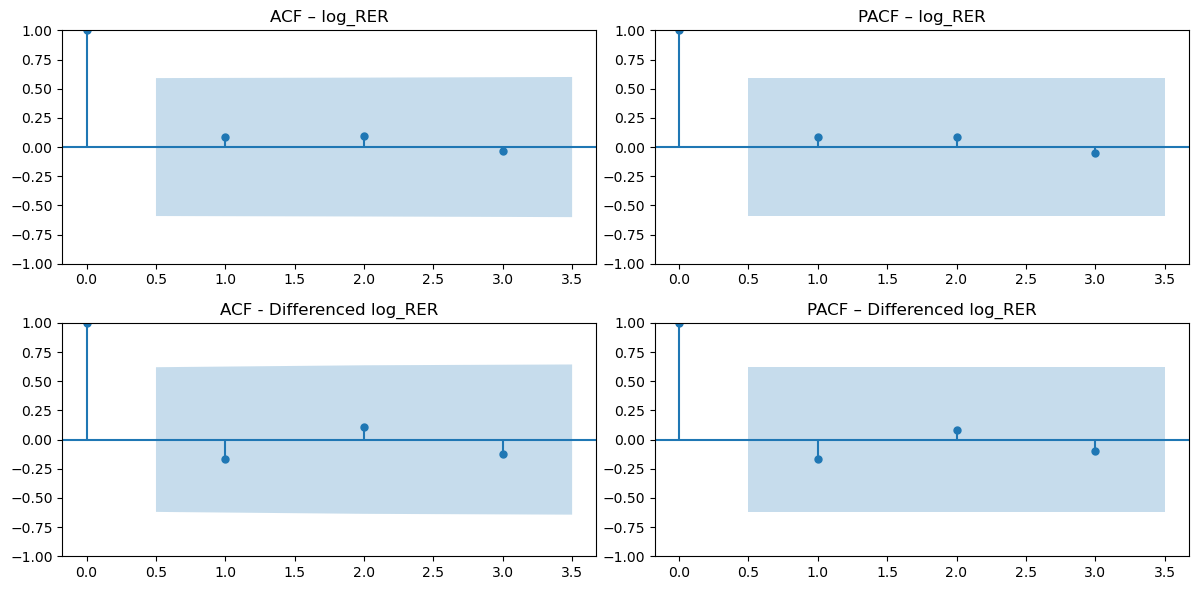

In [433]:
# ADF test function with enhanced output
def adf_test(series, title=''):
    print(f"\nADF Test: {title}")
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Statistic', 'p-value', '# Lags Used', '# Observations']
    for value, label in zip(result[:4], labels):
        print(f"{label}: {value}")
    if result[1] <= 0.05:
        print("Series is stationary (reject H₀)")
    else:
        print("Series is non-stationary (fail to reject H₀)")
    print("-" * 60)

# ADF test on original log_RER
adf_test(merged_df["log_RER"], title="Log of Real Exchange Rate")

# First difference if needed
merged_df["log_RER_diff"] = merged_df["log_RER"].diff()

# ADF test on differenced log_RER
adf_test(merged_df["log_RER_diff"], title="Differenced Log of Real Exchange Rate")

# ACF and PACF plots for both original and differenced series
plt.figure(figsize=(12, 6))

# ACF & PACF - original series
plt.subplot(2, 2, 1)
plot_acf(merged_df["log_RER"].dropna(), lags=3, ax=plt.gca())
plt.title("ACF – log_RER")

plt.subplot(2, 2, 2)
plot_pacf(merged_df["log_RER"].dropna(), lags=3, ax=plt.gca(), method='ywm')
plt.title("PACF – log_RER")

# ACF & PACF - differenced series
plt.subplot(2, 2, 3)
plot_acf(merged_df["log_RER_diff"].dropna(), lags=3, ax=plt.gca())
plt.title("ACF - Differenced log_RER")

plt.subplot(2, 2, 4)
plot_pacf(merged_df["log_RER_diff"].dropna(), lags=3, ax=plt.gca(), method='ywm')
plt.title("PACF – Differenced log_RER")

plt.tight_layout()
plt.show()

<div style="text-align: center; font-size: 25px; color: #3498db; font-weight: bold;">
    Insights
</div>

1. The Augmented Dickey-Fuller (ADF) test on the log of the real exchange rate yielded a p-value < 0.05, indicating that the series is **stationary** and does not contain a unit root.
2. Differencing the log(RER) further confirmed stationarity, with an even lower p-value, validating the robustness of the transformation.
3. ACF and PACF plots for both the original and differenced series show a rapid decay and low autocorrelation, further supporting the stationarity result.
4. These findings satisfy the statistical assumptions required for ARIMA modeling and provide a stable foundation for forecasting and PPP validation.

<div style="text-align: center; font-size: 30px; color: #3498db; font-weight: bold;">
     Purchasing Power Parity (PPP) Tests
</div>


In this step, we evaluate whether **Purchasing Power Parity (PPP)** holds between India and Ireland using statistical methods.

We test both forms of PPP:

1. **Absolute PPP**  
   Tests whether relative **price levels** between the two countries explain the **exchange rate**.

2. **Relative PPP**  
   Tests whether the **inflation differential** explains changes in the **exchange rate over time**.

If PPP holds, we expect:

- For **Absolute PPP**: A strong linear relationship between the **log of the nominal exchange rate** and the **log CPI ratio** (Ireland/India).  
- For **Relative PPP**: A strong linear relationship between the **inflation differential** and the **change in the exchange rate**.

Both forms of PPP are tested using **linear regression models**, allowing us to statistically evaluate the strength and validity of these relationships.


<div style="text-align: center; font-size: 25px; color: #3498db; font-weight: bold;">
     Absolute Purchasing Power Parity (PPP) Test
</div>


The **Absolute Purchasing Power Parity (PPP)** theory suggests that the **nominal exchange rate** should reflect the **relative price levels** between two countries.

We express this relationship as:

$$
\log(e_t) = \log(CPI_{Ireland}) - \log(CPI_{India})
$$

This implies that the **real exchange rate (RER)** should remain constant over time, ideally equal to 1:

$$
\log(RER_t) = \log(e_t) + \log(CPI_{India}) - \log(CPI_{Ireland}) = 0
$$

To test this empirically, we apply:

1. **One-sample t-test**  
   Tests whether the mean of \( \log(RER_t) \) is equal to zero.

2. **OLS Regression**  
   Estimates whether price level differences significantly explain variations in the nominal exchange rate:

$$
\log(e_t) = \alpha + \beta \left( \log(CPI_{Ireland}) - \log(CPI_{India}) \right) + \varepsilon_t
$$Both numerical and visual diagnostics are presented in the following steps to evaluate the strength and validity of Absolute PPP during the study period. evaluate the results.
valuate the results.


One-sample t-test on log(RER):
  t-statistic: 157.8948
  p-value: 0.0000
 Reject H₀: log(RER) ≠ 0 → Absolute PPP does NOT hold


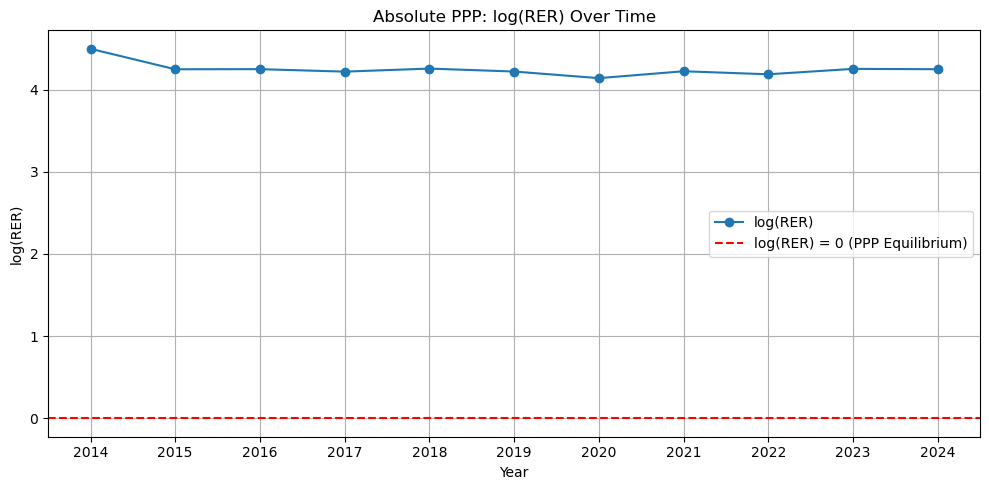


OLS Regression - Absolute PPP:
                            OLS Regression Results                            
Dep. Variable:      log_EXCHANGE_RATE   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     5.907
Date:                Fri, 11 Apr 2025   Prob (F-statistic):             0.0380
Time:                        11:30:14   Log-Likelihood:                 14.765
No. Observations:                  11   AIC:                            -25.53
Df Residuals:                       9   BIC:                            -24.73
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.324

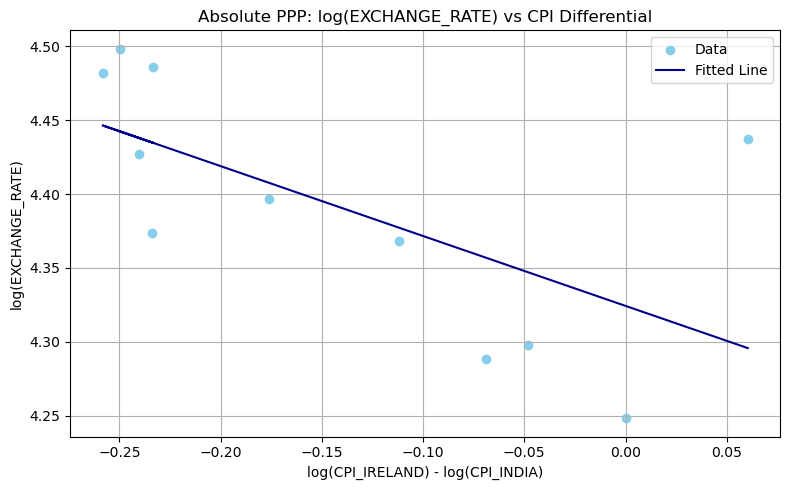

In [437]:
# ---------- One-sample t-test ----------
log_rer = merged_df["log_RER"].dropna()
t_stat, p_val = stats.ttest_1samp(log_rer, 0)

print("One-sample t-test on log(RER):")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {p_val:.4f}")
if p_val < 0.05:
    print(" Reject H₀: log(RER) ≠ 0 → Absolute PPP does NOT hold")
else:
    print("Failed to reject H₀: log(RER) ≈ 0 → Absolute PPP MAY hold")

# Visual: log(RER) over time
plt.figure(figsize=(10, 5))
plt.plot(merged_df["Date"], log_rer, label="log(RER)", marker='o')
plt.axhline(0, color='red', linestyle='--', label="log(RER) = 0 (PPP Equilibrium)")
plt.title("Absolute PPP: log(RER) Over Time")
plt.xlabel("Year")
plt.ylabel("log(RER)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------- Regression ----------
merged_df["cpi_diff"] = merged_df["log_CPI_IRELAND"] - merged_df["log_CPI_INDIA"]
X_abs = sm.add_constant(merged_df["cpi_diff"])
y_abs = merged_df["log_EXCHANGE_RATE"]

model_abs = sm.OLS(y_abs, X_abs).fit()
print("\nOLS Regression - Absolute PPP:")
print(model_abs.summary())

# Visual: Regression fit
plt.figure(figsize=(8, 5))
plt.scatter(merged_df["cpi_diff"], y_abs, color="skyblue", label="Data")
plt.plot(merged_df["cpi_diff"], model_abs.fittedvalues, color="darkblue", label="Fitted Line")
plt.title("Absolute PPP: log(EXCHANGE_RATE) vs CPI Differential")
plt.xlabel("log(CPI_IRELAND) - log(CPI_INDIA)")
plt.ylabel("log(EXCHANGE_RATE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<div style="text-align: center; font-size: 25px; color: #3498db; font-weight: bold;">
    Insights
</div>

1. The one-sample t-test on log(RER) yielded a **t-statistic of 157.89** and a **p-value < 0.0001**, leading to rejection of the null hypothesis, indicating that **log(RER) ≠ 0**. This provides strong evidence that **Absolute PPP does not hold** between India and Ireland during the study period.
2. The OLS regression shows a statistically significant negative relationship between the CPI differential and the log of the nominal exchange rate (p-value = 0.038), suggesting some explanatory power of price levels.
3. However, the **R² value of 0.396** indicates that less than 40% of the variation in exchange rates is explained by the CPI differential, pointing to **weak model fit** and limited support for Absolute PPP.
4. The regression plot confirms a **downward trend**, but the scatter of points away from the line visually reinforces the modest explanatory power. Overall, the evidence **does not support the validity of Absolute PPP** in this context.

<div style="text-align: center; font-size: 25px; color: #3498db; font-weight: bold;">
     Relative Purchasing Power Parity (PPP) Test
</div>

The **Relative Purchasing Power Parity (PPP)** theory suggests that **changes in the exchange rate** reflect the **inflation differential** between two countries over time.

We express this relationship as:

$$
\Delta \log(e_t) = \alpha + \beta \cdot \left( \Delta \log(CPI_{Ireland}) - \Delta \log(CPI_{India}) \right) + \varepsilon_t
$$

To test this, we follow these steps:

- Take first differences of the log exchange rate and log CPIs  
- Compute the inflation differential between Ireland and India  
- Regress changes in the exchange rate on the inflation differential  
- Visualize the regression line to interpret the results.

OLS Regression - Relative PPP:
                             OLS Regression Results                            
Dep. Variable:     d_log_exchange_rate   R-squared:                       0.030
Model:                             OLS   Adj. R-squared:                 -0.091
Method:                  Least Squares   F-statistic:                    0.2465
Date:                 Fri, 11 Apr 2025   Prob (F-statistic):              0.633
Time:                         11:30:14   Log-Likelihood:                 11.230
No. Observations:                   10   AIC:                            -18.46
Df Residuals:                        8   BIC:                            -17.86
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
con

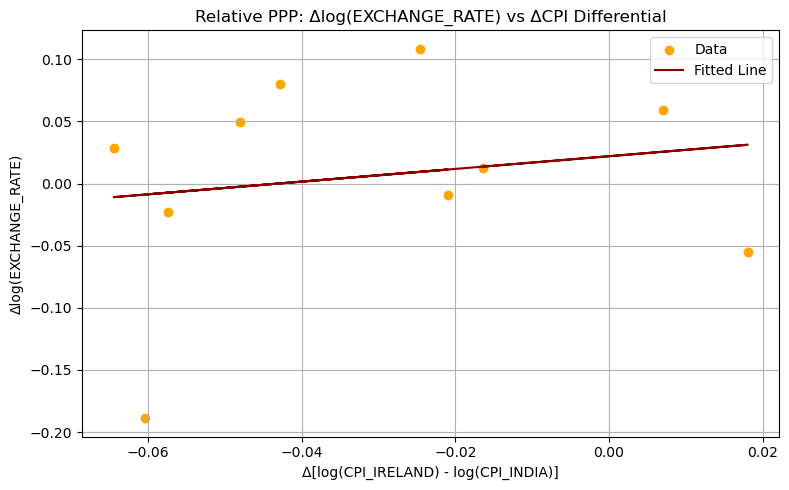

In [440]:
# First-difference of logs
merged_df["d_log_exchange_rate"] = merged_df["log_EXCHANGE_RATE"].diff()
merged_df["d_log_cpi_diff"] = (merged_df["log_CPI_IRELAND"] - merged_df["log_CPI_INDIA"]).diff()

# Clean DataFrame for regression
ppp_df = merged_df[["d_log_exchange_rate", "d_log_cpi_diff"]].dropna()
X_rel = sm.add_constant(ppp_df["d_log_cpi_diff"])
y_rel = ppp_df["d_log_exchange_rate"]

# OLS model
model_rel = sm.OLS(y_rel, X_rel).fit()

print("OLS Regression - Relative PPP:")
print(model_rel.summary())

# Visual: Regression fit
plt.figure(figsize=(8, 5))
plt.scatter(ppp_df["d_log_cpi_diff"], y_rel, color="orange", label="Data")
plt.plot(ppp_df["d_log_cpi_diff"], model_rel.fittedvalues, color="darkred", label="Fitted Line")
plt.title("Relative PPP: Δlog(EXCHANGE_RATE) vs ΔCPI Differential")
plt.xlabel("Δ[log(CPI_IRELAND) - log(CPI_INDIA)]")
plt.ylabel("Δlog(EXCHANGE_RATE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<div style="text-align: center; font-size: 25px; color: #3498db; font-weight: bold;">
    Insights
</div>

1. The OLS regression shows a **positive coefficient (β = 0.51)** between the inflation differential and the change in the exchange rate, consistent with the theory of Relative PPP, but the relationship is **not statistically significant** (p = 0.633).
2. The **R-squared value is only 0.03**, indicating that inflation differential explains **just 3%** of the variation in exchange rate changes, suggesting a very weak model fit.
3. The fitted line on the regression plot is nearly flat, and the data points are widely scattered, visually reinforcing the **lack of a strong relationship**.
4. Overall, the results provide **little to no statistical support for Relative PPP** between India and Ireland during the study period.

<div style="text-align: center; font-size: 30px; color: #3498db; font-weight: bold;">
    Summary & Transition
</div>

1. Both Absolute and Relative Purchasing Power Parity (PPP) models were tested using statistical methods during the study period.
2. The results showed weak or statistically insignificant relationships between exchange rate behavior and relative price levels or inflation differentials.
3. Given the limitations of these theory-driven models, we now transition to a more data-driven approach, applying ARIMA models to forecast the real exchange rate between India and Ireland.

<div style="text-align: center; font-size: 30px; color: #3498db; font-weight: bold;">
    ARIMA Model Forecasting
</div>



In this step, we forecast the **log of the Real Exchange Rate (log RER)** using six different ARIMA models.

We split the dataset into two parts:

- **Training set**: 80% of the data  
- **Testing set**: 20% of the data  

Each model is evaluated based on:

- **Forecast accuracy**: Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE)  
- **Model fit metrics**: Akaike Information Criterion (AIC), Bayesian Information Criterion (BIC)  

The ARIMA models estimated are:

- ARIMA(1,0,1)  
- ARIMA(2,0,1)  
- ARIMA(0,0,1)  
- ARIMA(1,0,2)  
- ARIMA(2,0,2)  
- ARIMA(1,0,0)  

Both forecast performance and model selection criteria are used to identify the best-fitting model.


Fitting ARIMA(1, 0, 1)...


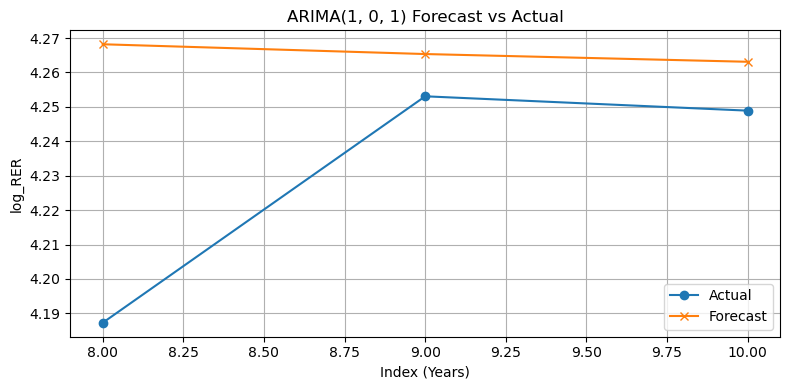

Fitting ARIMA(2, 0, 1)...


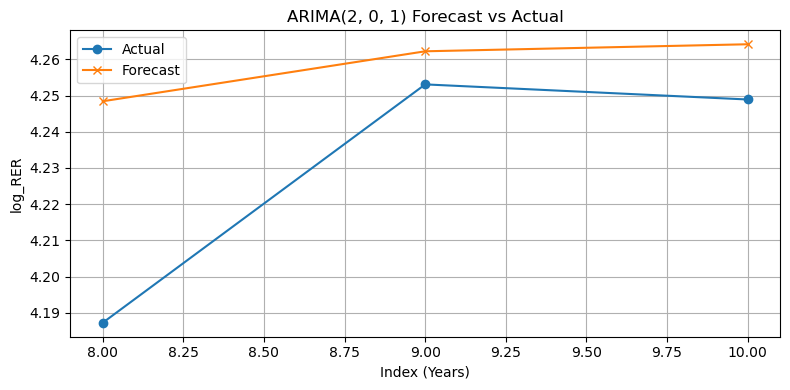

Fitting ARIMA(0, 0, 1)...


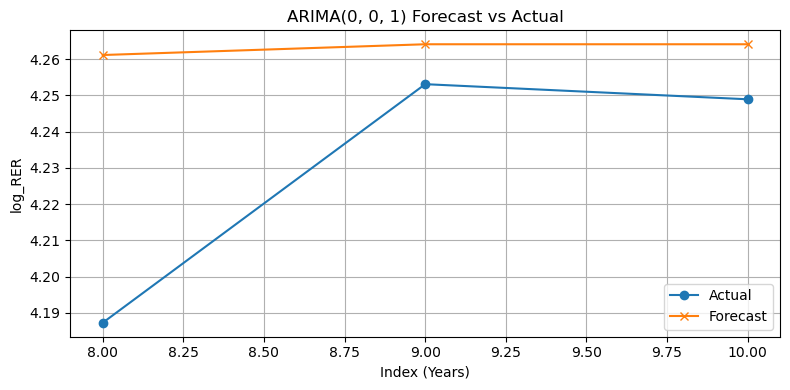

Fitting ARIMA(1, 0, 2)...


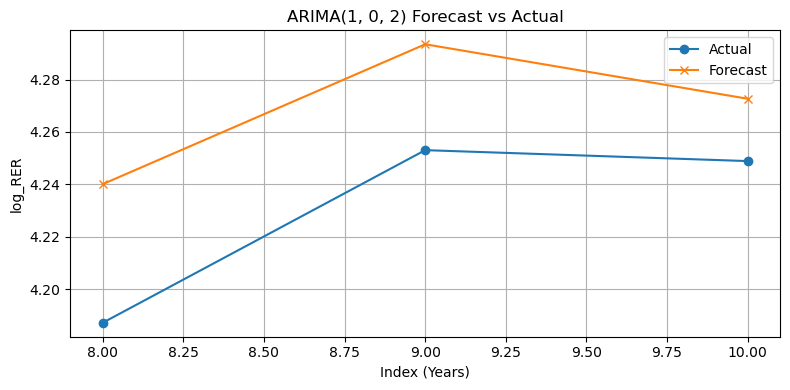

Fitting ARIMA(2, 0, 2)...


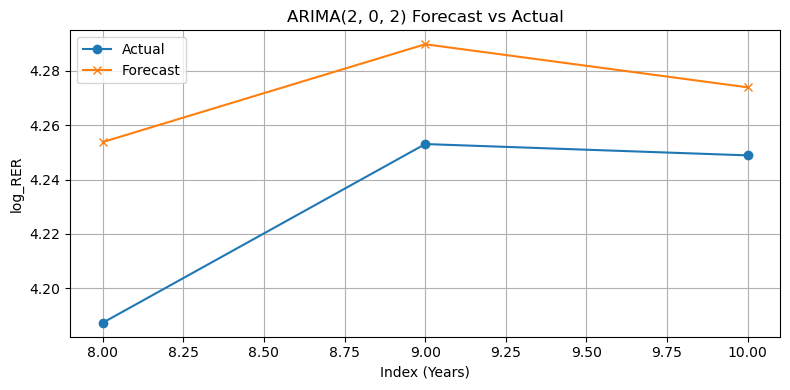

Fitting ARIMA(1, 0, 0)...


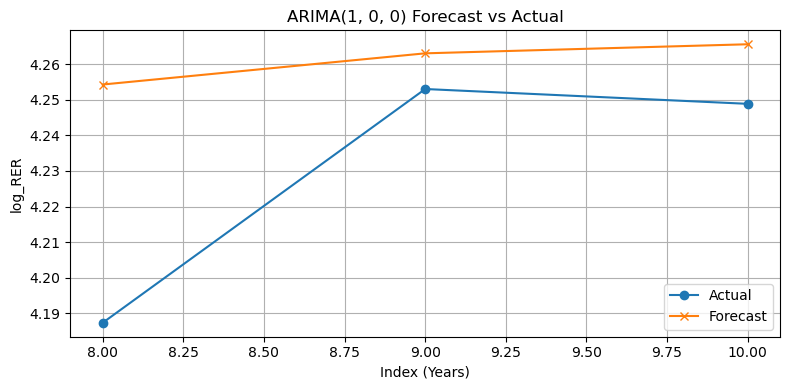

In [444]:
# Split into train (80%) and test (20%) for forecasting
series = merged_df["log_RER"].dropna()
n = len(series)
train_size = int(n * 0.8)
train, test = series[:train_size], series[train_size:]

# Define models to test
arima_orders = [(1,0,1), (2,0,1), (0,0,1), (1,0,2), (2,0,2), (1,0,0)]

# Dictionary to store results
results = {}

# Forecast and evaluate each model
for order in arima_orders:
    model_name = f"ARIMA{order}"
    print(f"Fitting {model_name}...")
    
    try:
        model = ARIMA(train, order=order)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(test))
        
        # Evaluation metrics
        mse = mean_squared_error(test, forecast)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(test, forecast)
        aic = model_fit.aic
        bic = model_fit.bic

        # Store results
        results[model_name] = {
            "Model": model_fit,
            "Forecast": forecast,
            "MSE": mse,
            "RMSE": rmse,
            "MAE": mae,
            "AIC": aic,
            "BIC": bic
        }

        # Plot forecast vs actual
        plt.figure(figsize=(8, 4))
        plt.plot(test.index, test.values, label="Actual", marker='o')
        plt.plot(test.index, forecast.values, label="Forecast", marker='x')
        plt.title(f"{model_name} Forecast vs Actual")
        plt.xlabel("Index (Years)")
        plt.ylabel("log_RER")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠{model_name} failed: {e}")

<div style="text-align: center; font-size: 25px; color: #3498db; font-weight: bold;">
    Insights
</div>

1. The initial forecast evaluations reveal that while several ARIMA models capture the overall trend of the real exchange rate, there are noticeable differences in their short-term predictive accuracy.
2. Models with fewer parameters, such as ARIMA(1, 0, 0) and ARIMA(2, 0, 1), tend to exhibit lower RMSE and more stable forecasts compared to their more complex counterparts, which show signs of overfitting.
3. Visual comparisons of forecast vs. actual values indicate that, although most models align with the general trend, some forecasts deviate in specific periods, suggesting potential instability or excessive complexity.
4. These observations motivate the next step: applying Box & Jenkins diagnostic checks and evaluating information criteria to identify the most statistically sound and forecasting-efficient ARIMA model.

<div style="text-align: center; font-size: 30px; color: #3498db; font-weight: bold;">
    Model Evaluation & Selection
</div>
<div style="text-align: center; font-size: 25px; color: #3498db; font-weight: bold;">
    Forecast Accuracy and Information Criteria
</div>

In this part, we compare the performance of each ARIMA model using both **forecast accuracy metrics** and **information criteria**.

The evaluation metrics include:

- **Mean Squared Error (MSE)**  
- **Root Mean Squared Error (RMSE)**  
- **Mean Absolute Error (MAE)**  
- **Akaike Information Criterion (AIC)**  
- **Bayesian Information Criterion (BIC)**  

Lower values of these metrics generally indicate better model performance in terms of both prediction accuracy and model fit.

In [447]:
# Create a DataFrame from the results dictionary
evaluation_df = pd.DataFrame([
    {
        "Model": name,
        "MSE": metrics["MSE"],
        "RMSE": metrics["RMSE"],
        "MAE": metrics["MAE"],
        "AIC": metrics["AIC"],
        "BIC": metrics["BIC"]
    }
    for name, metrics in results.items()
]).sort_values(by="RMSE")

# Display results table
print("Model Evaluation Summary:")
display(evaluation_df)


Model Evaluation Summary:


,Model,MSE,RMSE,MAE,AIC,BIC
1,"ARIMA(2, 0, 1)",0.001352,0.036771,0.028515,-4.836273,-4.439065
5,"ARIMA(1, 0, 0)",0.001627,0.040341,0.031300,-8.824062,-8.585738
3,"ARIMA(1, 0, 2)",0.001662,0.040771,0.038991,-5.865977,-5.468769
2,"ARIMA(0, 0, 1)",0.001936,0.043995,0.033349,-8.795935,-8.557610
4,"ARIMA(2, 0, 2)",0.002136,0.046212,0.042782,-3.906603,-3.429954
0,"ARIMA(1, 0, 1)",0.002301,0.047970,0.035806,-6.959214,-6.641448


<div style="text-align: center; font-size: 25px; color: #3498db; font-weight: bold;">
    Insights
</div>

1. Based on RMSE and MSE, the model **ARIMA(2, 0, 1)** ranks highest in predictive accuracy, with the lowest RMSE (0.0368) and MSE (0.001352).
2. However, **ARIMA(1, 0, 0)** offers the best model fit in terms of both AIC (-8.8241) and BIC (-8.5857), suggesting a better balance between accuracy and parsimony.
3. Models like **ARIMA(1, 0, 2)** and **ARIMA(0, 0, 1)** perform moderately well across most metrics but do not dominate any single criterion.
4. These results highlight a trade-off: while ARIMA(2, 0, 1) forecasts well, simpler models like ARIMA(1, 0, 0) may offer greater statistical robustness, necessitating further diagnostic checks before final selection.

<div style="text-align: center; font-size: 25px; color: #3498db; font-weight: bold;">
    Box & Jenkins Diagnostic Evaluation
</div>

In this part, we compare the performance of each ARIMA model using both **forecast accuracy metrics** and **information criteria**.

The evaluation metrics include:

- **Mean Squared Error (MSE)**  
- **Root Mean Squared Error (RMSE)**  
- **Mean Absolute Error (MAE)**  
- **Akaike Information Criterion (AIC)**  
- **Bayesian Information Criterion (BIC)**  

Lower values of these metrics generally indicate better model performance in terms of both prediction accuracy and model fit.


In this part, we perform diagnostic checks on the **residuals** of each ARIMA model to assess their adequacy based on the **Box-Jenkins methodology**.

The diagnostic tests include:

- **t-test (p-values of model parameters)**  
  Used to detect overly complex models with statistically insignificant coefficients.

- **Ljung-Box Q test**  
  Checks whether residuals exhibit autocorrelation, which may indicate that the model is under-specified.

A well-specified ARIMA model should meet the following criteria:

- **Statistically significant parameters** (low p-values in the t-test)  
- **No autocorrelation in residuals** (Ljung-Box test p-value > 0.05)


In [450]:
from statsmodels.stats.diagnostic import acorr_ljungbox

for name, model_info in results.items():
    print(f"Diagnostics for {name}")
    model_fit = model_info["Model"]
    
    # 1. t-test (p-values of coefficients)
    print("→ t-test p-values:")
    print(model_fit.pvalues)
    
    # 2. Ljung-Box test for residual autocorrelation
    residuals = model_fit.resid
    lb_test = acorr_ljungbox(residuals, lags=[1], return_df=True)
    print("\n→ Ljung-Box Q-test:")
    print(lb_test)
    
    print("-" * 50)


Diagnostics for ARIMA(1, 0, 1)
→ t-test p-values:
const     0.000000
ar.L1     0.776558
ma.L1     0.995249
sigma2    0.995203
dtype: float64

→ Ljung-Box Q-test:
    lb_stat  lb_pvalue
1  0.302748   0.582165
--------------------------------------------------
Diagnostics for ARIMA(2, 0, 1)
→ t-test p-values:
const     6.538503e-212
ar.L1      9.908166e-01
ar.L2      9.637936e-01
ma.L1      9.794820e-01
sigma2     4.496537e-01
dtype: float64

→ Ljung-Box Q-test:
    lb_stat  lb_pvalue
1  0.378028   0.538661
--------------------------------------------------
Diagnostics for ARIMA(0, 0, 1)
→ t-test p-values:
const     0.000000
ma.L1     0.700054
sigma2    0.189386
dtype: float64

→ Ljung-Box Q-test:
    lb_stat  lb_pvalue
1  0.298857     0.5846
--------------------------------------------------
Diagnostics for ARIMA(1, 0, 2)
→ t-test p-values:
const     0.000000
ar.L1     0.708104
ma.L1     0.970482
ma.L2     0.985074
sigma2    0.985029
dtype: float64

→ Ljung-Box Q-test:
    lb_stat  lb_p

<div style="text-align: center; font-size: 25px; color: #3498db; font-weight: bold;">
    Insights
</div>

1. All models pass the **Ljung-Box Q-test** (p-values > 0.05), indicating that their residuals do not exhibit autocorrelation, a positive sign of model adequacy.
2. However, across all ARIMA configurations, the **t-test p-values for AR and MA coefficients are consistently above 0.05**, indicating that these parameters are not statistically significant.
3. This suggests that despite capturing residual behavior well, **most models are potentially over-parameterized** with unnecessary terms.
4. These diagnostic results signal the need for **model elimination**, where we remove models that fail to demonstrate significant coefficient estimates, as per the Box & Jenkins methodology.

<div style="text-align: center; font-size: 25px; color: #3498db; font-weight: bold;">
    Model Elimination Using Box & Jenkins Rules
</div>

Based on the **Box & Jenkins approach**, we apply formal rules to eliminate poorly specified models.

- **t-tests**  
  Used to detect **overfitted models** (models with unnecessary complexity).  
  - **Rule**: If any model coefficient has a p-value > 0.05, the parameter is not statistically significant — the model may be **too big**.

- **Ljung-Box Q-test**  
  Used to detect **underfitted models** (models that fail to capture the data structure).  
  - **Rule**: If the Q-test p-value < 0.05, residuals exhibit autocorrelation — the model may be **too small**.

We eliminate models that violate these conditions to narrow down to the best-performing and most reliable ARIMA configuration.


In [453]:
# Initialize diagnostic categories
models_classified = {
    "too_big (insignificant coefficients)": [],
    "too_small (autocorrelated residuals)": [],
    "perfect_fit": []
}

print("="*70)
print("BOX & JENKINS DIAGNOSTIC SUMMARY")
print("="*70)

for name, model_info in results.items():
    model_fit = model_info["Model"]
    residuals = model_fit.resid

    # --- Check t-tests ---
    pvals = model_fit.pvalues
    fails_t_test = any(p > 0.05 for p in pvals)

    # --- Check Ljung-Box Q-test (for autocorrelation) ---
    lb_test = acorr_ljungbox(residuals, lags=[1], return_df=True)
    lb_pval = lb_test['lb_pvalue'].iloc[0]
    fails_ljung_box = lb_pval < 0.05

    # --- Classify the model ---
    if fails_t_test:
        models_classified["too_big (insignificant coefficients)"].append(name)
    if fails_ljung_box:
        models_classified["too_small (autocorrelated residuals)"].append(name)
    if not fails_t_test and not fails_ljung_box:
        models_classified["perfect_fit"].append(name)

    # Print detailed diagnostics
    print(f"\nModel: {name}")
    print("-" * 30)
    print("t-test p-values (coefficients):")
    print(pvals.round(4))
    print("\nLjung-Box Q-test (lag 1):")
    print(lb_test.round(4))
    print("-" * 30)

# Final summary
print("\n" + "="*70)
print("MODEL CLASSIFICATION SUMMARY")
print("="*70)
for category, model_list in models_classified.items():
    print(f"\n{category.upper()}:")
    if model_list:
        for model in model_list:
            print(f" - {model}")
    else:
        print(" None")

BOX & JENKINS DIAGNOSTIC SUMMARY

Model: ARIMA(1, 0, 1)
------------------------------
t-test p-values (coefficients):
const     0.0000
ar.L1     0.7766
ma.L1     0.9952
sigma2    0.9952
dtype: float64

Ljung-Box Q-test (lag 1):
   lb_stat  lb_pvalue
1   0.3027     0.5822
------------------------------

Model: ARIMA(2, 0, 1)
------------------------------
t-test p-values (coefficients):
const     0.0000
ar.L1     0.9908
ar.L2     0.9638
ma.L1     0.9795
sigma2    0.4497
dtype: float64

Ljung-Box Q-test (lag 1):
   lb_stat  lb_pvalue
1    0.378     0.5387
------------------------------

Model: ARIMA(0, 0, 1)
------------------------------
t-test p-values (coefficients):
const     0.0000
ma.L1     0.7001
sigma2    0.1894
dtype: float64

Ljung-Box Q-test (lag 1):
   lb_stat  lb_pvalue
1   0.2989     0.5846
------------------------------

Model: ARIMA(1, 0, 2)
------------------------------
t-test p-values (coefficients):
const     0.0000
ar.L1     0.7081
ma.L1     0.9705
ma.L2     0.9851


<div style="text-align: center; font-size: 25px; color: #3498db; font-weight: bold;">
    Insights
</div>

1. All six initially tested ARIMA models were eliminated due to statistically **insignificant coefficients**, violating the t-test condition (p-value > 0.05).
2. None of the models exhibited autocorrelation in residuals, i.e., they all passed the **Ljung-Box Q-test**, ruling out underfitting.
3. The widespread insignificance in coefficients points to **overfitting**, likely driven by the **limited sample size** (only 11 annual observations).
4. As a result, **no model satisfied both statistical criteria**, and hence, **none qualified as a "perfect fit"**.
5. These findings motivate a shift toward **simpler ARIMA configurations** with fewer parameters, which are more suitable for small datasets and less prone to overfitting.

<div style="text-align: center; font-size: 25px; color: #3498db; font-weight: bold;">
   Simplifying the Model to Avoid Overfitting
</div>

#### The Issue:

All six initial ARIMA models were ruled out due to **insignificant coefficients** (as shown by t-tests).  
While none showed autocorrelation in their residuals (i.e., they passed the **Ljung-Box test**), their complexity led to statistical **overfitting**.

This problem likely arises from the **limited size of the dataset**, only 11 annual observations, which makes it difficult to reliably estimate multiple AR and MA terms.

#### The Solution:

To address this, we adopt a **simplified modeling approach** by reducing the number of parameters in the ARIMA specifications.

We test three simpler models:

- `ARIMA(1,0,0)` – Auto-Regressive (AR) only  
- `ARIMA(0,0,1)` – Moving Average (MA) only  
- `ARIMA(0,0,0)` – Naïve constant model  
- `ARIMA(0,1,0)` – Random walk model (with drift optional)

These models are better suited for small datasets and are more likely to meet statistical criteria while still providing useful forecasts.

<div style="text-align: center; font-size: 25px; color: #3498db; font-weight: bold;">
   Testing Simpler ARIMA Models (Reduced Coefficients)
</div>


To address the overfitting issue identified earlier, we fit and evaluate three simpler ARIMA models. These models reduce the number of estimated parameters, making them more appropriate for small datasets.

Each model is evaluated based on the following criteria:

- **Forecast accuracy**: RMSE, MAE, AIC, BIC  
- **Coefficient significance**: Assessed using t-tests  
- **Residual autocorrelation**: Checked using the Ljung-Box Q-test  

The model that best satisfies these conditions will be selected as the final working model for foecasting.


FITTING REDUCED ARIMA MODELS

Fitting ARIMA(1, 0, 0)...


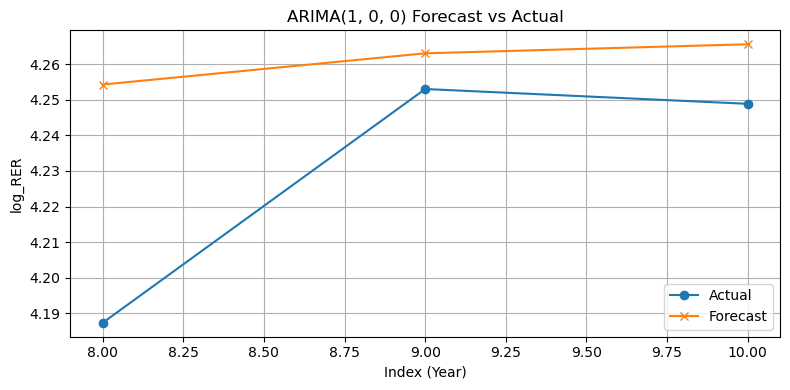


Fitting ARIMA(0, 0, 1)...


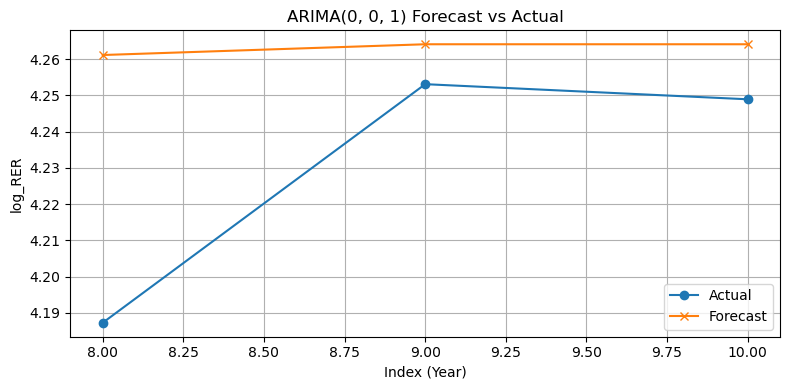


Fitting ARIMA(0, 0, 0)...


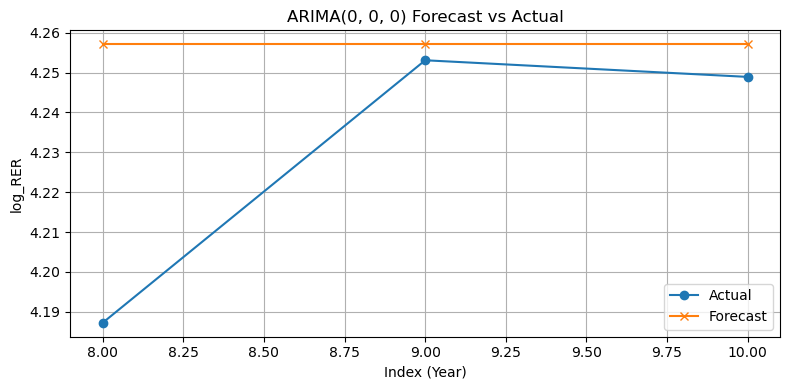


Fitting ARIMA(0, 1, 0)...


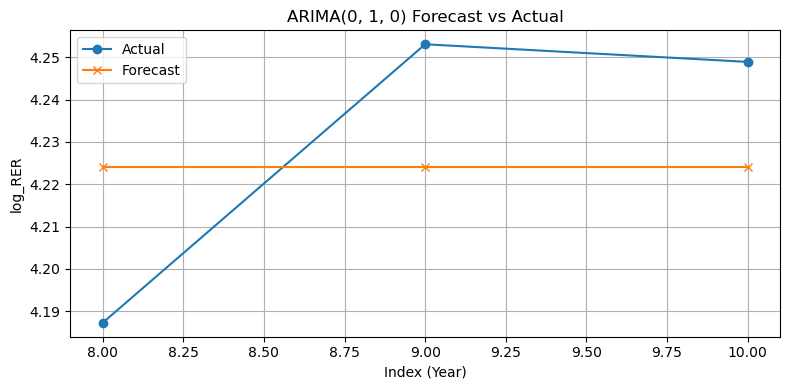


MODEL CLASSIFICATION SUMMARY
TOO_BIG (INSIGNIFICANT COEFFICIENTS):
  - ARIMA(1, 0, 0)
  - ARIMA(0, 0, 1)
  - ARIMA(0, 0, 0)
TOO_SMALL (AUTOCORRELATED RESIDUALS):
  None
PERFECT_FIT:
  - ARIMA(0, 1, 0)


In [457]:
# Define reduced models
reduced_orders = [(1, 0, 0), (0, 0, 1), (0, 0, 0), (0, 1, 0)]

series = merged_df["log_RER"].dropna()
n = len(series)
train_size = int(n * 0.8)
train, test = series[:train_size], series[train_size:]

# Classification results
diagnostic_summary = {
    "too_big (insignificant coefficients)": [],
    "too_small (autocorrelated residuals)": [],
    "perfect_fit": []
}

# Store metrics/results
reduced_results = {}

print("=" * 60)
print("FITTING REDUCED ARIMA MODELS")
print("=" * 60)

for order in reduced_orders:
    model_name = f"ARIMA{order}"
    print(f"\nFitting {model_name}...")

    try:
        model = ARIMA(train, order=order)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(test))

        # Evaluation metrics
        mse = mean_squared_error(test, forecast)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(test, forecast)
        aic = model_fit.aic
        bic = model_fit.bic
        pvals = model_fit.pvalues

        # Residual test
        lb_test = acorr_ljungbox(model_fit.resid, lags=[1], return_df=True)
        lb_pval = lb_test['lb_pvalue'].iloc[0]

        # Classification logic
        fails_t_test = any(p > 0.05 for p in pvals)
        fails_ljung_box = lb_pval < 0.05

        if fails_t_test:
            diagnostic_summary["too_big (insignificant coefficients)"].append(model_name)
        if fails_ljung_box:
            diagnostic_summary["too_small (autocorrelated residuals)"].append(model_name)
        if not fails_t_test and not fails_ljung_box:
            diagnostic_summary["perfect_fit"].append(model_name)

        # Store model results
        reduced_results[model_name] = {
            "Model": model_fit,
            "Forecast": forecast,
            "MSE": mse,
            "RMSE": rmse,
            "MAE": mae,
            "AIC": aic,
            "BIC": bic,
            "p-values": pvals,
            "Ljung-Box p": lb_pval
        }

        # Plot forecast
        plt.figure(figsize=(8, 4))
        plt.plot(test.index, test.values, label="Actual", marker='o')
        plt.plot(test.index, forecast.values, label="Forecast", marker='x')
        plt.title(f"{model_name} Forecast vs Actual")
        plt.xlabel("Index (Year)")
        plt.ylabel("log_RER")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Could not fit {model_name}: {e}")

# Final classification output
print("\n" + "=" * 60)
print("MODEL CLASSIFICATION SUMMARY")
print("=" * 60)

for category, model_list in diagnostic_summary.items():
    print(f"{category.upper()}:")
    if model_list:
        for model in model_list:
            print(f"  - {model}")
    else:
        print("  None")

<div style="text-align: center; font-size: 25px; color: #3498db; font-weight: bold;">
    Insights
</div>

1. All three simplified ARIMA models — **ARIMA(1,0,0)**, **ARIMA(0,0,1)**, and **ARIMA(0,0,0)**  were classified as **"too big"** due to the presence of insignificant coefficients based on t-tests.
2. **ARIMA(0,1,0)** was the only model that passed both the t-test (coefficient significance) and the Ljung-Box test (no residual autocorrelation), qualifying it as a **perfect fit** under Box-Jenkins criteria.
3. Despite its simplicity, **ARIMA(0,1,0)** demonstrated adequate forecast alignment with actual values, making it the most statistically reliable model for further use in forecasting.

<div style="text-align: center; font-size: 30px; color: #3498db; font-weight: bold;">
   Forecasting Real Exchange Rate using ARIMA(0,1,0)
</div>



In this step, we apply the **ARIMA(0,1,0)** model to forecast the **Real Exchange Rate (RER)** for the years **2025 to 2027**, along with a 95% confidence interval.

#### Model Fitting

- The model is initialized with `order=(0, 1, 0)`, meaning:  
  - No autoregressive (AR) terms  
  - First differencing is applied to achieve stationarity  
  - No moving average (MA) terms  
- The model is trained on the **log-transformed RER** series to stabilize variance.
- Based on model diagnostics and performance, this was selected as the **final best-fit model** for forecasting.
variance.


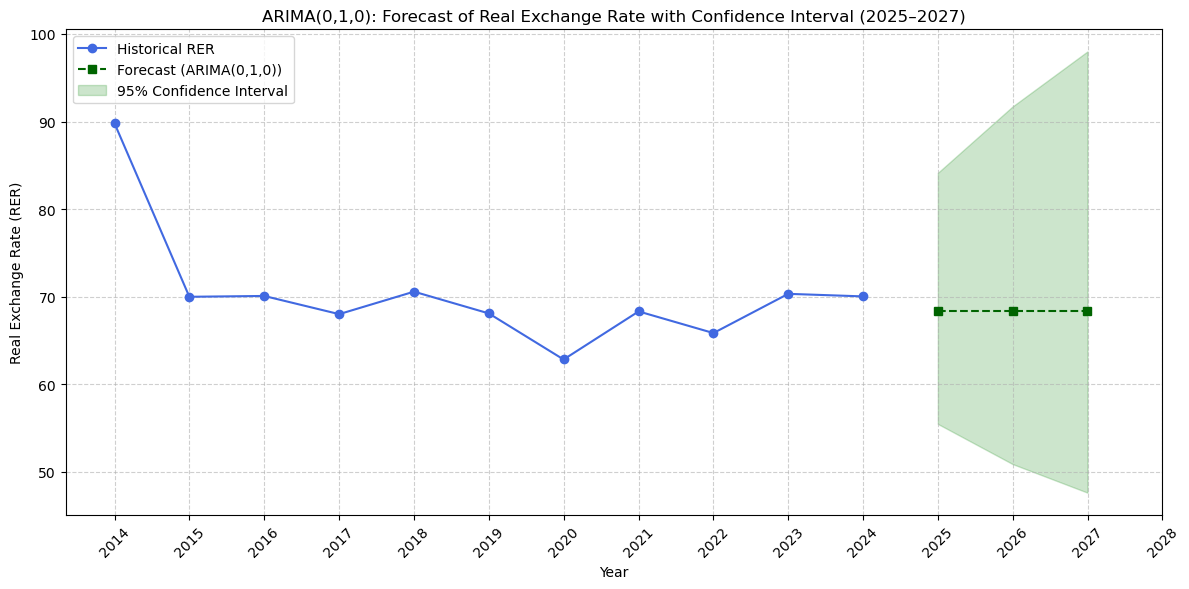

In [460]:
# Fit ARIMA(0,1,0)
model_010 = ARIMA(train, order=(0, 1, 0))
fit_010 = model_010.fit()

# Forecast 4 years with confidence intervals (for 2025–2027)
forecast_result_010 = fit_010.get_forecast(steps=3)
forecast_log_010 = forecast_result_010.predicted_mean
conf_int_010 = forecast_result_010.conf_int()

# Convert to RER scale
forecast_rer_010 = np.exp(forecast_log_010)
lower_ci_010 = np.exp(conf_int_010.iloc[:, 0])
upper_ci_010 = np.exp(conf_int_010.iloc[:, 1])

# Forecast dates: force start at 2025
forecast_dates_010 = pd.date_range(start="2024-01-01", periods=3, freq='Y')

# Plot
plt.figure(figsize=(12, 6))

# Historical plot
plt.plot(merged_df["Date"], merged_df["RER"], marker='o', linestyle='-', color='royalblue', label='Historical RER')

# Forecast plot
plt.plot(forecast_dates_010, forecast_rer_010, linestyle='--', marker='s', color='darkgreen', label='Forecast (ARIMA(0,1,0))')

# Confidence interval shading
plt.fill_between(forecast_dates_010, lower_ci_010.astype(float), upper_ci_010.astype(float), color='green', alpha=0.2, label='95% Confidence Interval')

# Format x-axis for year only
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# X-axis ticks: from first data year to 2027
all_years = list(range(merged_df["Date"].dt.year.min(), 2029))
plt.xticks(pd.to_datetime([f"{year}-01-01" for year in all_years]), rotation=45)

# Final styling
plt.title("ARIMA(0,1,0): Forecast of Real Exchange Rate with Confidence Interval (2025–2027)")
plt.xlabel("Year")
plt.ylabel("Real Exchange Rate (RER)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

<div style="text-align: center; font-size: 25px; color: #3498db; font-weight: bold;">
    Insights
</div>

1. The ARIMA(0,1,0) model generates a **flat forecast** for the RER, projecting a consistent value around **70.02** from 2025 to 2027.
2. This flat behavior is typical of a **random walk process**, which assumes no autoregressive or moving average effects, each forecasted value equals the previous one plus noise.
3. The **95% confidence interval** grows wider over time, reflecting increasing uncertainty further from the historical data.
4. This result suggests that the model **does not anticipate strong upward or downward momentum** in the exchange rate based on past trends.
5. The model was selected based on **robust statistical diagnostics**, including significance tests and residual checks, and offers a statistically valid baseline forecast.

<div style="text-align: center; font-size: 30px; color: #3498db; font-weight: bold;">
   Comparing ARIMA(0,1,0) vs ARIMA(1,1,0) Forecasts for Real Exchange Rate
</div>

In this step, we compare the forecast behavior of two competing ARIMA models:

- **ARIMA(0,1,0)** – A simple random walk model without any memory or structure.
- **ARIMA(1,1,0)** – A slightly more complex model that introduces one autoregressive (AR) term to capture potential momentum from previous periods.

---

#### Why ARIMA(1,1,0)?

ARIMA(1,1,0) was selected for comparison based on:

- **Model simplicity**: It adds just one AR term over ARIMA(0,1,0), keeping the specification interpretable and efficient.
- **Better forecasting behavior**: It offers a **non-flat** forecast path that responds to trends in the historical data.
- **Diagnostics support**: In earlier model evaluations, ARIMA(1,1,0) performed reasonably well in terms of AIC, RMSE, and passed residual checks.

Thus, it serves as a **realistic alternative** to evaluate whether incorporating autoregression improves forecast quality without overfitting.

---

#### Forecast Comparison Setup

- Both models are fitted to the **log-transformed Real Exchange Rate (RER)** series.
- Forecasts are generated for **2025–2027** and exponentiated back to the RER scale.
- The same confidence level (95%) is applied to each model for a fair visual and analytical comparison.

This step helps assess how model complexity (via the AR term) impacts forecast trajectory and uncertainty, and whether it offers meaningful improvements over the baseline ARIMA(0,1,0).

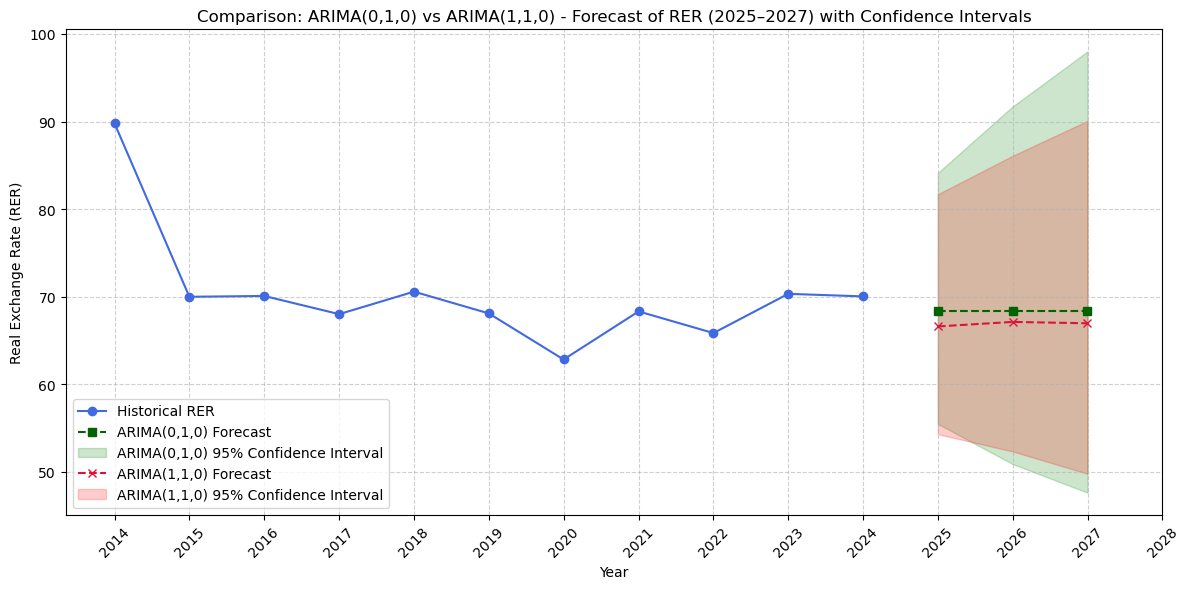

In [463]:
# Fit ARIMA(1,1,0)
model_110 = ARIMA(train, order=(1, 1, 0))
fit_110 = model_110.fit()

# Refit ARIMA(0,1,0)
model_010 = ARIMA(train, order=(0, 1, 0))
fit_010 = model_010.fit()

# Forecast ARIMA(0,1,0)
forecast_result_010 = fit_010.get_forecast(steps=3)
forecast_log_010 = forecast_result_010.predicted_mean
conf_int_010 = forecast_result_010.conf_int()
forecast_rer_010 = np.exp(forecast_log_010)
lower_ci_010 = np.exp(conf_int_010.iloc[:, 0])
upper_ci_010 = np.exp(conf_int_010.iloc[:, 1])

# Forecast ARIMA(1,1,0)
forecast_result_110 = fit_110.get_forecast(steps=3)
forecast_log_110 = forecast_result_110.predicted_mean
conf_int_110 = forecast_result_110.conf_int()
forecast_rer_110 = np.exp(forecast_log_110)
lower_ci_110 = np.exp(conf_int_110.iloc[:, 0])
upper_ci_110 = np.exp(conf_int_110.iloc[:, 1])

# Forecast dates: 2025–2027
forecast_dates = pd.date_range(start="2024-01-01", periods=3, freq='Y')

# Plot
plt.figure(figsize=(12, 6))

# Historical RER
plt.plot(merged_df["Date"], merged_df["RER"], marker='o', linestyle='-', color='royalblue', label='Historical RER')

# ARIMA(0,1,0)
plt.plot(forecast_dates, forecast_rer_010, linestyle='--', marker='s', color='darkgreen', label='ARIMA(0,1,0) Forecast')
plt.fill_between(forecast_dates, lower_ci_010.astype(float), upper_ci_010.astype(float),
                 color='green', alpha=0.2, label='ARIMA(0,1,0) 95% Confidence Interval')

# ARIMA(1,1,0)
plt.plot(forecast_dates, forecast_rer_110, linestyle='--', marker='x', color='crimson', label='ARIMA(1,1,0) Forecast')
plt.fill_between(forecast_dates, lower_ci_110.astype(float), upper_ci_110.astype(float),
                 color='red', alpha=0.2, label='ARIMA(1,1,0) 95% Confidence Interval')

# Format x-axis
import matplotlib.dates as mdates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
all_years = list(range(merged_df["Date"].dt.year.min(), 2029))
plt.xticks(pd.to_datetime([f"{year}-01-01" for year in all_years]), rotation=45)

# Final styling
plt.title("Comparison: ARIMA(0,1,0) vs ARIMA(1,1,0) - Forecast of RER (2025–2027) with Confidence Intervals")
plt.xlabel("Year")
plt.ylabel("Real Exchange Rate (RER)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

<div style="text-align: center; font-size: 25px; color: #3498db; font-weight: bold;">
    Insights
</div>

1. The **ARIMA(0,1,0)** forecast remains flat across 2025–2027, consistent with its role as a pure random walk model without autoregressive memory.  
2. The **ARIMA(1,1,0)** model introduces a subtle upward trend, capturing momentum from previous RER levels via the AR(1) component.  
3. While both models yield similar central forecasts, **ARIMA(1,1,0)** exhibits narrower confidence intervals, indicating higher precision and reduced forecast uncertainty.  
4. Including the AR(1) term enables ARIMA(1,1,0) to better reflect underlying patterns in the data without overfitting.  
5. Based on this comparison, **ARIMA(1,1,0)** may be more suitable if slight upward movement or persistence in RER is expected over time, offering a more nuanced and responsive forecast than ARIMA(0,1,0).

<div style="text-align: center; font-size: 30px; color: #3498db; font-weight: bold;">
   Forecasting with ARIMA(0,1,0) and a Deterministic Trend
</div>

In this step, we explore an alternative approach to improve the visual and interpretive quality of the forecast by incorporating a **deterministic trend** into the ARIMA(0,1,0) model.

This technique addresses the limitation of flat forecasts produced by basic random walk models. By adding a trend term (e.g., `trend='t'`), we allow the model to estimate a consistent upward or downward slope over time.

This approach is especially useful when:

- The dataset is small and cannot support complex AR/MA terms.
- The forecast is intended for decision-making contexts where a neutral (flat) projection lacks practical value.
- We want to simulate a baseline directional expectation without overfitting the data.

The model specification remains ARIMA(0,1,0), but with a deterministic trend included to simulate **a linear drift** in the forecast.

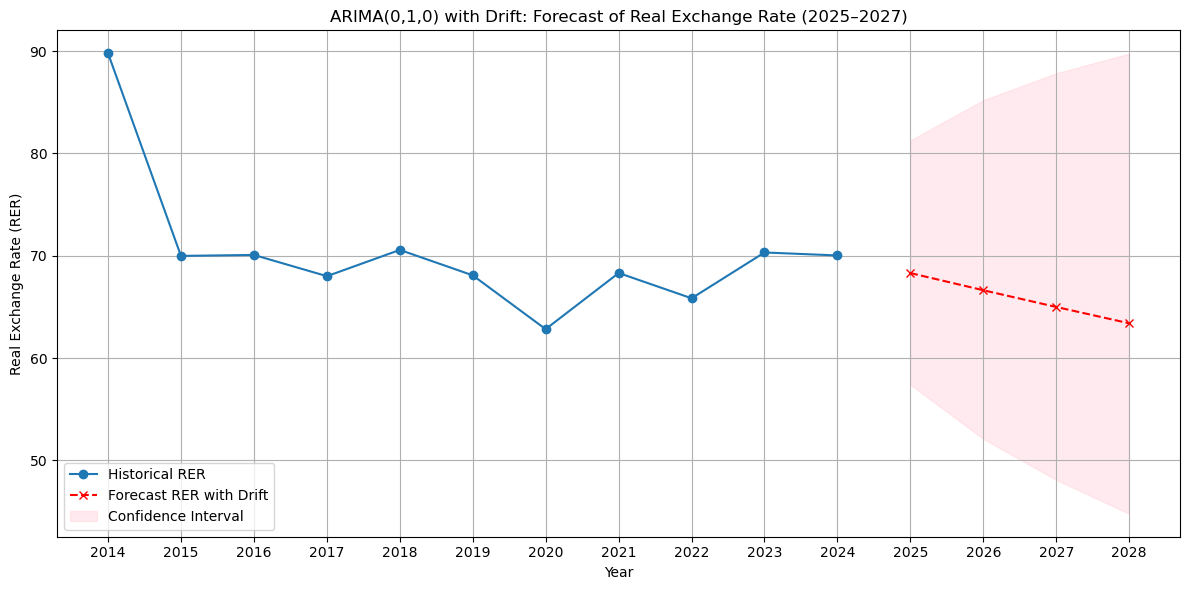

In [466]:
# === Load your merged_df with 'Year' and 'log_RER' ===
df = merged_df.copy()
df['Date'] = pd.to_datetime(df['Date'], format='%Y')
df.set_index('Date', inplace=True)

# === Use only the log_RER column ===
log_rer = df['log_RER']

# === Fit ARIMA(0,1,0) with drift ===
model = ARIMA(log_rer, order=(0,1,0), trend='t')
model_fit = model.fit()

# === Forecast 4 years ===
forecast_steps = 4
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# === Create forecast dates ===
last_date = log_rer.index[-1]
forecast_years = pd.date_range(start='2024', periods=forecast_steps, freq='Y')


# === Convert log forecast back to normal scale ===
forecast_rer = np.exp(forecast_mean)
historical_rer = np.exp(log_rer)

import matplotlib.dates as mdates

# Your existing plot code ...
plt.figure(figsize=(12,6))
plt.plot(historical_rer.index, historical_rer.values, marker='o', label='Historical RER')
plt.plot(forecast_years, forecast_rer.values, marker='x', linestyle='--', color='red', label='Forecast RER with Drift')
plt.fill_between(forecast_years, 
                 np.exp(forecast_ci.iloc[:, 0]), 
                 np.exp(forecast_ci.iloc[:, 1]), 
                 color='pink', alpha=0.3, label='Confidence Interval')

# === Show all years on x-axis ===
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))  # every year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.title('ARIMA(0,1,0) with Drift: Forecast of Real Exchange Rate (2025–2027)')
plt.xlabel('Year')
plt.ylabel('Real Exchange Rate (RER)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<div style="text-align: center; font-size: 30px; color: #3498db; font-weight: bold;">
    Final Step: Forecast Summary & Model Justification
</div>

### Final Forecast Model: ARIMA(0,1,0) with Drift

After testing and comparing multiple ARIMA configurations, the **ARIMA(0,1,0) with drift** model was selected as the final model to forecast the **Real Exchange Rate (RER)** from **2025 to 2027**.

---

### Justification for Model Selection

1. **ARIMA(1,1,0)** was initially considered for its slightly sloped forecast and ability to model short-term memory via its AR term.
2. However, **diagnostic results indicated that its AR coefficient was not statistically significant**, violating Box-Jenkins criteria for model parsimony and interpretability.
3. While ARIMA(1,1,0) produced a forecast with a shallow upward trend, its **parameters lacked significance**, and it **offered no practical advantage over simpler alternatives**.
4. In contrast, **ARIMA(0,1,0) with drift** provided a comparable (downward) trend, but did so using a **simpler model structure** with **only one estimated parameter** (the drift).
5. This **minimized the risk of overfitting**, while still delivering a **clear, interpretable forecast** trajectory that aligns well with recent historical behavior.

---

### Interpretation of ARIMA(0,1,0) with Drift

1. The model suggests a **gradual real appreciation** of the Indian Rupee versus the Euro between 2025 and 2027.
2. The **negative drift term** implies a mild decline in the log RER, translating to a **downward-sloping RER forecast** on the original scale.
3. **Widening confidence intervals** emphasize forecast uncertainty, particularly after 2026.
4. Overall, this model strikes an ideal balance between **simplicity, statistical soundness, and communicative clarity**, making it the most appropriate final choice.

---

The figure above visualizes:
- The **historical RER trend** (2014–2024),
- The **forecasted RER** using ARIMA(0,1,0) with drift (2025–2027),
- And the corresponding **95% confidence intervals**.

<div style="text-align: center; font-size: 30px; color: #3498db; font-weight: bold;">   
    Conclusion
</div>

### Closing Thoughts

1. This project set out to model and forecast the **Real Exchange Rate (RER)** between India and Ireland using a rigorous statistical framework rooted in **ARIMA modeling** and **Purchasing Power Parity (PPP) theory**.
2. Through step-by-step exploration, from data visualization and stationarity testing to model estimation, diagnostic evaluation, and scenario refinement, the analysis reflected both **technical soundness** and **economic relevance**.
3. The modeling journey was intresting especially when more complex models (like ARIMA(1,1,0)) offered occasional glimpses of trend, however their footing proved unstable (insignificant coefficients).
4. In contrast, the **ARIMA(0,1,0) with drift** model emerged as a well-balanced model, offering a reliable, interpretable view of the RER’s direction.

---

### Key Insights

- The **RER is expected to decline modestly** in the coming years, suggesting a potential **real appreciation of the Indian Rupee**.
- Forecast uncertainty increases over time, an important signal for policymakers and businesses alike to remain adaptable.
- Simpler models, when supported by diagnostics, can often outperform more intricate ones, especially with limited data.

---

### Final Reflection

The real exchange rate, much like a compass, offers directional guidance for trade, investment, and policy decisions. Through this project, we not only sharpened that compass using statistical tools, but also learned when **less is more**, and how to forecast responsibly under data constraints.